In [1]:
# Importing needed libraries

import torch, time, os, pickle
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F



from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import grad
from helpers import *
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance

In [2]:
class Generator(nn.Module):
    
    def __init__(self, input_dim=100, output_dim=1, input_size=32):
        super(Generator, self).__init__()
        self.input_dim = input_dim 
        self.output_dim = output_dim 
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        # The following layers are used to upsample the input
        #  noise and generate an output image. 
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        # This function initializes the weights and biases of the 
        # generator's layers:
        initialize_weights(self) 

    def forward(self, input):
        '''
        The input to the forward method represents the input noise 
        to the generator model. It returns the generated output image.
        '''
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4)) # reshapes x to match the expected size for the subsequent transposed convolutional layers. 
        x = self.deconv(x)
        return x

In [3]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            # nn.Sigmoid(),
        )
        # This function initializes the weights and biases of the 
        # discriminator's layers:
        initialize_weights(self)

    def forward(self, input):
        '''
        The input to the forward method represents the input image
        It returns the output prediction, which represents the discriminator's assessment of the input image.
        '''
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)
        return x

In [4]:
class WGAN(object):
    def __init__(self, epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2):
    
        self.epoch = epoch
        self.batch_size = batch_size
        self.save_dir = save_dir
        self.result_dir = result_dir
        self.device = device
        self.dataset = dataset
        self.input_size = input_size    # Default: 32

        self.model_name = 'WGAN'        
        self.z_dim = 62                 # s an integer that represents the dimensionality of the (Gaussian) random input vector used by the generator.
        self.d_param_max = 0.01         # Clipping value
        self.iteration_g_per_d = 5      # specifies the number of iterations of the generator per discriminator iteration. 
                                        # This controls the relative training frequency of the generator and discriminator.

        # transformation to be applied on data in the DataLoader function

        self.inception=InceptionScore(normalize=True)
        self.f=FrechetInceptionDistance(feature=64,normalize=True)

        transform = transforms.Compose([
                                        transforms.Resize((input_size, input_size)), 
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                        ])
        
        if self.dataset == 'cifar10':
                self.data_loader = DataLoader(
                    datasets.CIFAR10('data/cifar10', train=True, download=True, transform=transform),
                    batch_size=batch_size, shuffle=True)
        elif self.dataset == 'mnist':
                self.data_loader = DataLoader(
                    datasets.MNIST('data/mnist', train=True, download=True, transform=transform),
                    batch_size=batch_size, shuffle=True)
        

        data = self.data_loader.__iter__().__next__()[0]

        # Initialize generator, discriminator and optimizers
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=lrG, betas=(beta1, beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=lrD, betas=(beta1, beta2))

        if self.device == 'cuda':
            self.G.cuda()
            self.D.cuda()

        # Fixed noise: By setting up a fixed noise vector, the WGAN can generate consistent
        # samples from the generator over the course of training. This allows for visualizing
        # the progression of generated images or comparing them across different training iterations.
        self.sample_z = torch.rand((self.batch_size, self.z_dim))
        if self.device == 'cuda':
            self.sample_z = self.sample_z.cuda()

    def train(self):
        self.D_losses = []
        self.G_losses = []
        self.inception_scores = []
        self.fid=[] 

        self.y_real = torch.ones(self.batch_size, 1) # Initialize labels for real samples (i.e. 1)
        self.y_fake = torch.zeros(self.batch_size, 1) # Initialize labels for fake samples (i.e. 0)

        if self.device == 'cuda':
            self.y_real = self.y_real.cuda()
            self.y_fake = self.y_fake.cuda()

        self.D.train() #D network in train mode

        print('Start training!')

        for epoch in range(self.epoch):
            self.G.train() #G network in train mode

            for iter, (x_train, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_noise = torch.rand((self.batch_size, self.z_dim))

                if self.device == 'cuda':
                    x_train = x_train.cuda()
                    z_noise = z_noise.cuda()

                # PART 1: UPDATE THE DISCRIMINATOR
                self.D_optimizer.zero_grad()

                D_real = self.D(x_train) # Computes the discriminator output for real data
                D_real_loss = -torch.mean(D_real) # Calculates the loss for the discriminator on real data. 
                                                  # The objective is to maximize the average output of the discriminator for real data.

                G_ = self.G(z_noise) # Generates fake data using the generator
                D_fake = self.D(G_) # Computes the discriminator output for fake data.
                D_fake_loss = torch.mean(D_fake) # Calculates the loss for the discriminator on fake data. 
                                                 # The objective is to minimize the average output of the discriminator for fake data.

                D_loss = D_real_loss + D_fake_loss # Calculates the total discriminator loss as the sum of the losses on real and fake data.

                D_loss.backward()
                self.D_optimizer.step()

                # Clipping D parameters to a specified range to enforce Lipschitz continuity.
                for p in self.D.parameters():
                    p.data.clamp_(-self.d_param_max, self.d_param_max)

                if ((iter+1) % self.iteration_g_per_d) == 0:
                    # PART 2: UPDATE THE GENERATOR
                    self.G_optimizer.zero_grad()

                    G_ = self.G(z_noise)
                    D_fake = self.D(G_)
                    G_loss = -torch.mean(D_fake) # Calculates the generator loss as the negative average output of the discriminator for fake data. 
                                                 # The objective is to maximize the average output of the discriminator for the generated fake data.

                    self.G_losses.append(G_loss.item())

                    G_loss.backward()

                    self.G_optimizer.step()

                    self.D_losses.append(D_loss.item())
                
                #if (iter % 100) == 0:
                #   self.inception_scores.append(self.calculateInceptionScore())

            print(f'Epoch: {epoch}/{self.epoch}')
            print(f'Average Discriminator loss: {np.mean(self.D_losses)}')
            print(f'Average Generator loss: {np.mean(self.G_losses)}')

            with torch.no_grad():
                self.visualize_results((epoch+1))
                score=self.IS()
                print('inception_score:',score[0])
                self.inception_scores.append(score[0].item())
                distance=self.FID()
                print('fid:',distance,'\n')
                self.inception_scores.append(distance.item())

        print("Training finished.")

        #self.save()
        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.G_losses, self.D_losses, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)
        is_plot(self.inception_scores)
    
    def IS(self):
        self.G.eval()
        images = self.G(self.sample_z)
        self.inception.update(images.cpu())
        IS=self.inception.compute()   
        return IS
        
    def FID(self):
        self.G.eval()
        imagesG = self.G(self.sample_z)
        imagesR=self.data_loader.__iter__().__next__()[0]
        self.f.update(imagesR.cpu(), real=True)
        self.f.update(imagesG.cpu(), real=False)
        FID=self.f.compute()
        return FID

    def visualize_results(self, epoch):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        samples = self.G(self.sample_z)
        
        if self.device == 'cuda':
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)


        samples = (samples + 1) / 2
        save_images(samples, [8, 8],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')
    
    def print_networks(self):
        print('---------- Networks architecture -------------')
        print(self.G)
        print(self.D)
        print('-----------------------------------------------')


    '''
    def save(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        torch.save(self.G.state_dict(), os.path.join(save_dir, self.model_name + '_G.pkl'))
        torch.save(self.D.state_dict(), os.path.join(save_dir, self.model_name + '_D.pkl'))

        with open(os.path.join(save_dir, self.model_name + '_history.pkl'), 'wb') as f:
            pickle.dump(self.train_hist, f)

    def load(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        self.G.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_G.pkl')))
        self.D.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_D.pkl')))
    '''

In [5]:
class WGAN_GP(object):
    def __init__(self, epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2):
        # parameters
        self.epoch = epoch
        self.dataset = dataset
        self.batch_size = batch_size
        self.save_dir = save_dir
        self.result_dir = result_dir
        self.device = device
        self.input_size = input_size

        self.model_name = 'WGAN_GP'
        self.z_dim = 62
        self.lambda_ = 10
        self.iteration_g_per_d = 5

        self.inception=InceptionScore(normalize=True)
        self.f=FrechetInceptionDistance(feature=64,normalize=True)               
        
        # transformation to be applied on data in the DataLoader function
        transform = transforms.Compose([
                                transforms.Resize((self.input_size, self.input_size)), 
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                ])

        if self.dataset == 'cifar10':
                self.data_loader = DataLoader(
                    datasets.CIFAR10('data/cifar10', train=True, download=False, transform=transform),
                    batch_size=batch_size, shuffle=True)
        elif self.dataset == 'mnist':
                self.data_loader = DataLoader(
                    datasets.MNIST('data/mnist', train=True, download=True, transform=transform),
                    batch_size=batch_size, shuffle=True)
        
        data = self.data_loader.__iter__().__next__()[0]

        # Initialization of optimizers and of generator and discriminator
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=lrG, betas=(beta1, beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=lrD, betas=(beta1, beta2))

        if self.device == 'cuda':
            self.G.cuda()
            self.D.cuda()

        # Fixed noise: By setting up a fixed noise vector, the WGAN can generate consistent
        # samples from the generator over the course of training. This allows for visualizing
        # the progression of generated images or comparing them across different training iterations.
        self.sample_z = torch.rand((self.batch_size, self.z_dim))
        if self.device == 'cuda':
            self.sample_z = self.sample_z.cuda()

    def train(self):
        self.G_losses = []
        self.D_losses = []

        self.inception_scores = []
        self.fid=[]
        
        self.y_real = torch.ones(self.batch_size, 1)
        self.y_fake = torch.zeros(self.batch_size, 1)

        if self.device == 'cuda':
            self.y_real = self.y_real.cuda()
            self.y_fake =  self.y_fake.cuda()

        self.D.train() #Discriminator in train mode
        print('Start training!')

        for epoch in range(self.epoch):
            self.G.train() #Generator in train mode

            for iter, (x_train, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_noise = torch.rand((self.batch_size, self.z_dim))
                if self.device == 'cuda':
                    x_train = x_train.cuda()
                    z_noise = z_noise.cuda()

                # PART 1: UPDATE THE DISCRIMINATOR
                self.D_optimizer.zero_grad()

                D_real = self.D(x_train)
                D_real_loss = -torch.mean(D_real)

                G_ = self.G(z_noise)
                D_fake = self.D(G_)
                D_fake_loss = torch.mean(D_fake)

                # Gradient penalty
                alpha = torch.rand((self.batch_size, 1, 1, 1))
                if self.device == 'cuda':
                    alpha = alpha.cuda()

                x_hat = alpha * x_train.data + (1 - alpha) * G_.data
                x_hat.requires_grad = True

                pred_hat = self.D(x_hat)
                if self.device == 'cuda':
                    gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()).cuda(),
                                 create_graph=True, retain_graph=True, only_inputs=True)[0]
                else:
                    gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()),
                                     create_graph=True, retain_graph=True, only_inputs=True)[0]

                gradient_penalty = self.lambda_ * ((gradients.view(gradients.size()[0], -1).norm(2, 1) - 1) ** 2).mean()

                D_loss = D_real_loss + D_fake_loss + gradient_penalty #loss with gradient penalty

                D_loss.backward()
                self.D_optimizer.step()

                if ((iter+1) % self.iteration_g_per_d) == 0:
                    # PART 2: UPDATE THE GENERATOR
                    self.G_optimizer.zero_grad()

                    G_ = self.G(z_noise)
                    D_fake = self.D(G_)
                    G_loss = -torch.mean(D_fake)
                    self.G_losses.append(G_loss.item())

                    G_loss.backward()
                    self.G_optimizer.step()

                    self.D_losses.append(D_loss.item())
                
            print(f'Epoch: {epoch+1}/{self.epoch}')
            print(f'Average Discriminator loss: {np.mean(self.D_losses)}')
            print(f'Average Generator loss: {np.mean(self.G_losses)}\n')

            with torch.no_grad():
                self.visualize_results((epoch+1))
                score=self.IS()
                print('inception_score:',score[0])
                self.inception_scores.append(score[0].item())
                distance=self.FID()
                print('fid:',distance,'\n')
                self.inception_scores.append(distance.item())

        print("Training finished!")

        #self.save()
        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.G_losses, self.D_losses, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)
        is_plot(self.inception_scores)
    
    def IS(self):
        self.G.eval()
        images = self.G(self.sample_z)
        self.inception.update(images.cpu())
        IS=self.inception.compute()   
        return IS
    
    def FID(self):
        self.G.eval()
        imagesG = self.G(self.sample_z)
        imagesR=self.data_loader.__iter__().__next__()[0]
        self.f.update(imagesR.cpu(), real=True)
        self.f.update(imagesG.cpu(), real=False)
        FID=self.f.compute()
        return FID

    def visualize_results(self, epoch, fix=True):

        '''
        By calling this method during the training loop, you can visualize and save the 
        generated samples at regular intervals to monitor the progress 
        of the generator's output over the course of training.
        '''

        self.G.eval() # set the generator in evaluation mode.

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        samples = self.G(self.sample_z) # These samples represent the generator's output at the given epoch
        
        # The dimensions are transposed to match the image format
        if self.device == 'cuda':
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2 # Normalizes the samples by scaling their pixel values from the range [-1, 1] to the range [0, 1]
        save_images(samples, [8, 8],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')

    def print_networks(self):
        print('---------- Networks architecture -------------')
        print(self.G)
        print(self.D)
        print('-----------------------------------------------')

    '''
    def save(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        torch.save(self.G.state_dict(), os.path.join(save_dir, self.model_name + '_G.pkl'))
        torch.save(self.D.state_dict(), os.path.join(save_dir, self.model_name + '_D.pkl'))

        with open(os.path.join(save_dir, self.model_name + '_history.pkl'), 'wb') as f:
            pickle.dump(self.train_hist, f)

    def load(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        self.G.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_G.pkl')))
        self.D.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_D.pkl')))
    '''

In [6]:
# PARAMETERS

# Define dataset
dataset = 'cifar10'

# Define WGAN type (WGAN or WGAN_GP)
gan_type = 'WGAN_GP'

# Define number of epoch
epoch = 100

# Define batch_size
batch_size = 64

# Define input_size
input_size = 32

# Define directory for saving results and models
save_dir = 'models'
result_dir = 'results'

# Defining learning rates
lrG = 0.0002        # Generator
lrD = 0.0002        # Discriminator

# Adam beta parameters
beta1 = 0.5
beta2 = 0.999

# 'cuda' if GPU is available, 'cpu' else
device = 'cuda' if torch.cuda.is_available() else 'cpu'


wgan = WGAN(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)
wgan_gp = WGAN_GP(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)


'''
if gan_type == 'WGAN':
    wgan = WGAN(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)
elif gan_type == 'WGAN_GP':
    wgan = WGAN_GP(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)
'''

/home/ytian/.conda/envs/swav/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Files already downloaded and verified


"\nif gan_type == 'WGAN':\n    wgan = WGAN(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)\nelif gan_type == 'WGAN_GP':\n    wgan = WGAN_GP(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)\n"

Start training!


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 0/100
Average Discriminator loss: -0.01257175643546268
Average Generator loss: 0.0026338156189572495
inception_score: tensor(1.3971)
fid: tensor(18.5162) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 1/100
Average Discriminator loss: -0.01368706935019686
Average Generator loss: 0.003921580058000146
inception_score: tensor(1.7412)
fid: tensor(12.3190) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 2/100
Average Discriminator loss: -0.012391131014053702
Average Generator loss: 0.0037322587901206477
inception_score: tensor(1.9162)
fid: tensor(9.8255) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 3/100
Average Discriminator loss: -0.012058962954399295
Average Generator loss: 0.003726756609863421
inception_score: tensor(1.9984)
fid: tensor(9.0673) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 4/100
Average Discriminator loss: -0.011791246669152036
Average Generator loss: 0.0037881229836411643
inception_score: tensor(2.0774)
fid: tensor(7.7922) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 5/100
Average Discriminator loss: -0.01151444835928627
Average Generator loss: 0.0037887972532780236
inception_score: tensor(2.1575)
fid: tensor(6.8764) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 6/100
Average Discriminator loss: -0.011992757006944072
Average Generator loss: 0.004097970608433034
inception_score: tensor(2.1402)
fid: tensor(6.9670) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 7/100
Average Discriminator loss: -0.013169028861552644
Average Generator loss: 0.004683579875967179
inception_score: tensor(2.1351)
fid: tensor(6.7604) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 8/100
Average Discriminator loss: -0.01300486891468764
Average Generator loss: 0.004577080738627331
inception_score: tensor(2.1555)
fid: tensor(6.3542) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 9/100
Average Discriminator loss: -0.012466600918634914
Average Generator loss: 0.004273208162190619
inception_score: tensor(2.1688)
fid: tensor(5.9964) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 10/100
Average Discriminator loss: -0.012295208845720659
Average Generator loss: 0.004077518520356288
inception_score: tensor(2.1972)
fid: tensor(5.5974) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 11/100
Average Discriminator loss: -0.01204800836801127
Average Generator loss: 0.003941514648672598
inception_score: tensor(2.2337)
fid: tensor(5.1530) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 12/100
Average Discriminator loss: -0.011897659611532784
Average Generator loss: 0.0038874390064573367
inception_score: tensor(2.2640)
fid: tensor(5.1457) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 13/100
Average Discriminator loss: -0.011931277155784903
Average Generator loss: 0.003930696173457086
inception_score: tensor(2.2810)
fid: tensor(5.0066) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 14/100
Average Discriminator loss: -0.011867369153401535
Average Generator loss: 0.003934679510631314
inception_score: tensor(2.3010)
fid: tensor(4.7578) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 15/100
Average Discriminator loss: -0.011882312097534454
Average Generator loss: 0.003961035117894285
inception_score: tensor(2.3189)
fid: tensor(4.5173) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 16/100
Average Discriminator loss: -0.011853312256501575
Average Generator loss: 0.003991131084295728
inception_score: tensor(2.3349)
fid: tensor(4.4310) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 17/100
Average Discriminator loss: -0.012327656977208983
Average Generator loss: 0.0042345364223660715
inception_score: tensor(2.3304)
fid: tensor(4.3786) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 18/100
Average Discriminator loss: -0.012249471568194559
Average Generator loss: 0.004220986936287773
inception_score: tensor(2.3369)
fid: tensor(4.2619) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 19/100
Average Discriminator loss: -0.012222080515978935
Average Generator loss: 0.004266135158323801
inception_score: tensor(2.3584)
fid: tensor(4.1490) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 20/100
Average Discriminator loss: -0.012048110890820406
Average Generator loss: 0.004221795721647503
inception_score: tensor(2.3635)
fid: tensor(4.0230) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 21/100
Average Discriminator loss: -0.011982070388629112
Average Generator loss: 0.0042072486331352806
inception_score: tensor(2.3811)
fid: tensor(3.9034) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 22/100
Average Discriminator loss: -0.01191041539173011
Average Generator loss: 0.004186365644041706
inception_score: tensor(2.3907)
fid: tensor(3.8048) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 23/100
Average Discriminator loss: -0.012110073827610687
Average Generator loss: 0.004290053360585798
inception_score: tensor(2.4125)
fid: tensor(3.8703) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 24/100
Average Discriminator loss: -0.012337226471639812
Average Generator loss: 0.00440237218052901
inception_score: tensor(2.4183)
fid: tensor(3.7693) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 25/100
Average Discriminator loss: -0.012172703627304425
Average Generator loss: 0.004328604985185261
inception_score: tensor(2.4320)
fid: tensor(3.6405) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 26/100
Average Discriminator loss: -0.012447842505900565
Average Generator loss: 0.004440061381540304
inception_score: tensor(2.4390)
fid: tensor(3.6573) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 27/100
Average Discriminator loss: -0.012524691939602019
Average Generator loss: 0.0044668862046402975
inception_score: tensor(2.4395)
fid: tensor(3.5649) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 28/100
Average Discriminator loss: -0.012388961931015241
Average Generator loss: 0.004395778460601648
inception_score: tensor(2.4546)
fid: tensor(3.4675) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 29/100
Average Discriminator loss: -0.012266818282398909
Average Generator loss: 0.0043271549771256666
inception_score: tensor(2.4597)
fid: tensor(3.3759) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 30/100
Average Discriminator loss: -0.012437814791689048
Average Generator loss: 0.00440126314509567
inception_score: tensor(2.4966)
fid: tensor(3.5251) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 31/100
Average Discriminator loss: -0.012769735564000793
Average Generator loss: 0.004548687055817551
inception_score: tensor(2.5073)
fid: tensor(3.4586) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 32/100
Average Discriminator loss: -0.012604997206754565
Average Generator loss: 0.0044715660712187485
inception_score: tensor(2.5183)
fid: tensor(3.3828) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 33/100
Average Discriminator loss: -0.012509651476431545
Average Generator loss: 0.004399394805199992
inception_score: tensor(2.5251)
fid: tensor(3.2918) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 34/100
Average Discriminator loss: -0.012418236526105837
Average Generator loss: 0.004334474275649785
inception_score: tensor(2.5248)
fid: tensor(3.2227) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 35/100
Average Discriminator loss: -0.012346172298450588
Average Generator loss: 0.0042864627125404915
inception_score: tensor(2.5307)
fid: tensor(3.1355) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 36/100
Average Discriminator loss: -0.012610765750571483
Average Generator loss: 0.004377666216464872
inception_score: tensor(2.5507)
fid: tensor(3.1729) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 37/100
Average Discriminator loss: -0.01273349966142286
Average Generator loss: 0.00441389958930079
inception_score: tensor(2.5595)
fid: tensor(3.1136) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 38/100
Average Discriminator loss: -0.012581284837700463
Average Generator loss: 0.0043532142654982755
inception_score: tensor(2.5612)
fid: tensor(3.0305) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 39/100
Average Discriminator loss: -0.012468993359848704
Average Generator loss: 0.004288871664739301
inception_score: tensor(2.5730)
fid: tensor(2.9333) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 40/100
Average Discriminator loss: -0.012364572037490515
Average Generator loss: 0.004200378830291794
inception_score: tensor(2.5741)
fid: tensor(2.8837) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 41/100
Average Discriminator loss: -0.012287900527699049
Average Generator loss: 0.00413770526216063
inception_score: tensor(2.5697)
fid: tensor(2.8488) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 42/100
Average Discriminator loss: -0.012206863829052533
Average Generator loss: 0.004031167495364634
inception_score: tensor(2.5711)
fid: tensor(2.7908) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 43/100
Average Discriminator loss: -0.012007676947487495
Average Generator loss: 0.003850686303193595
inception_score: tensor(2.5713)
fid: tensor(2.7304) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 44/100
Average Discriminator loss: -0.011857562743538946
Average Generator loss: 0.003626518457846949
inception_score: tensor(2.5789)
fid: tensor(2.6552) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 45/100
Average Discriminator loss: -0.011668525080343798
Average Generator loss: 0.0032754325905376773
inception_score: tensor(2.5844)
fid: tensor(2.5880) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 46/100
Average Discriminator loss: -0.011514959591019462
Average Generator loss: 0.0030465431441983816
inception_score: tensor(2.5848)
fid: tensor(2.5344) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 47/100
Average Discriminator loss: -0.011413025607200526
Average Generator loss: 0.0030103672461001597
inception_score: tensor(2.5841)
fid: tensor(2.4688) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 48/100
Average Discriminator loss: -0.011330779708641015
Average Generator loss: 0.0029800112526952565
inception_score: tensor(2.5842)
fid: tensor(2.4163) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 49/100
Average Discriminator loss: -0.011257279134685329
Average Generator loss: 0.0029481323824797866
inception_score: tensor(2.5830)
fid: tensor(2.3797) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 50/100
Average Discriminator loss: -0.011184592461453733
Average Generator loss: 0.0029152305137484526
inception_score: tensor(2.5880)
fid: tensor(2.3419) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 51/100
Average Discriminator loss: -0.01110233533564484
Average Generator loss: 0.002859407487691683
inception_score: tensor(2.5908)
fid: tensor(2.2922) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 52/100
Average Discriminator loss: -0.011033532114350124
Average Generator loss: 0.0028220204688374543
inception_score: tensor(2.5948)
fid: tensor(2.2527) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 53/100
Average Discriminator loss: -0.010975833545927436
Average Generator loss: 0.002789900831932534
inception_score: tensor(2.5942)
fid: tensor(2.2259) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 54/100
Average Discriminator loss: -0.010905548811697245
Average Generator loss: 0.002739130475330038
inception_score: tensor(2.6010)
fid: tensor(2.1981) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 55/100
Average Discriminator loss: -0.01082338484886663
Average Generator loss: 0.0026513266939647666
inception_score: tensor(2.6047)
fid: tensor(2.1805) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 56/100
Average Discriminator loss: -0.010771450635902359
Average Generator loss: 0.0026229494305590024
inception_score: tensor(2.6078)
fid: tensor(2.1625) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 57/100
Average Discriminator loss: -0.010723326623978995
Average Generator loss: 0.0025912606455677526
inception_score: tensor(2.6178)
fid: tensor(2.1339) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 58/100
Average Discriminator loss: -0.01067365087375215
Average Generator loss: 0.0025610739879391694
inception_score: tensor(2.6210)
fid: tensor(2.0996) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 59/100
Average Discriminator loss: -0.010635401689504427
Average Generator loss: 0.0025372111680246594
inception_score: tensor(2.6332)
fid: tensor(2.0671) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 60/100
Average Discriminator loss: -0.010592417181791734
Average Generator loss: 0.002515815406768402
inception_score: tensor(2.6356)
fid: tensor(2.0383) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 61/100
Average Discriminator loss: -0.010557952728899778
Average Generator loss: 0.002497341499906292
inception_score: tensor(2.6383)
fid: tensor(2.0095) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 62/100
Average Discriminator loss: -0.010519560767007387
Average Generator loss: 0.0024789524071917764
inception_score: tensor(2.6490)
fid: tensor(1.9909) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 63/100
Average Discriminator loss: -0.010477073598132427
Average Generator loss: 0.002448772961164408
inception_score: tensor(2.6563)
fid: tensor(1.9672) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 64/100
Average Discriminator loss: -0.010442668296948041
Average Generator loss: 0.002421473642965151
inception_score: tensor(2.6529)
fid: tensor(1.9381) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 65/100
Average Discriminator loss: -0.010406501742315987
Average Generator loss: 0.002396670299949704
inception_score: tensor(2.6558)
fid: tensor(1.9148) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 66/100
Average Discriminator loss: -0.010364873055249484
Average Generator loss: 0.002370960843642644
inception_score: tensor(2.6565)
fid: tensor(1.9059) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 67/100
Average Discriminator loss: -0.010326641661978756
Average Generator loss: 0.002343576367972713
inception_score: tensor(2.6610)
fid: tensor(1.8858) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 68/100
Average Discriminator loss: -0.010288838642767757
Average Generator loss: 0.0023206176754965034
inception_score: tensor(2.6647)
fid: tensor(1.8526) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 69/100
Average Discriminator loss: -0.010251524271137524
Average Generator loss: 0.002299842830812756
inception_score: tensor(2.6695)
fid: tensor(1.8310) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 70/100
Average Discriminator loss: -0.010208605355764124
Average Generator loss: 0.002266328237003963
inception_score: tensor(2.6717)
fid: tensor(1.8034) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 71/100
Average Discriminator loss: -0.010171046770149631
Average Generator loss: 0.0022396087823925884
inception_score: tensor(2.6816)
fid: tensor(1.7771) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 72/100
Average Discriminator loss: -0.010137351938731444
Average Generator loss: 0.002210552503035372
inception_score: tensor(2.6790)
fid: tensor(1.7609) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 73/100
Average Discriminator loss: -0.01009957425986025
Average Generator loss: 0.0021803084597949714
inception_score: tensor(2.6835)
fid: tensor(1.7404) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 74/100
Average Discriminator loss: -0.010064085968993962
Average Generator loss: 0.0021492333007314362
inception_score: tensor(2.6883)
fid: tensor(1.7241) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 75/100
Average Discriminator loss: -0.010027860844829763
Average Generator loss: 0.0021200152865106328
inception_score: tensor(2.6945)
fid: tensor(1.6973) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 76/100
Average Discriminator loss: -0.009991785349258481
Average Generator loss: 0.002090641319722444
inception_score: tensor(2.6976)
fid: tensor(1.6844) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 77/100
Average Discriminator loss: -0.009958520379194105
Average Generator loss: 0.002066835109336573
inception_score: tensor(2.7026)
fid: tensor(1.6677) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 78/100
Average Discriminator loss: -0.009924297594173502
Average Generator loss: 0.00203313931938414
inception_score: tensor(2.7092)
fid: tensor(1.6450) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 79/100
Average Discriminator loss: -0.009890034838766345
Average Generator loss: 0.001998081868277542
inception_score: tensor(2.7104)
fid: tensor(1.6277) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 80/100
Average Discriminator loss: -0.009859109453651644
Average Generator loss: 0.0019661521116504377
inception_score: tensor(2.7123)
fid: tensor(1.6139) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 81/100
Average Discriminator loss: -0.009837385786924894
Average Generator loss: 0.0019371263442692994
inception_score: tensor(2.7137)
fid: tensor(1.5976) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 82/100
Average Discriminator loss: -0.009805238534727366
Average Generator loss: 0.0019142854352459154
inception_score: tensor(2.7129)
fid: tensor(1.5837) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 83/100
Average Discriminator loss: -0.009778214508478147
Average Generator loss: 0.001891486767115031
inception_score: tensor(2.7152)
fid: tensor(1.5704) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 84/100
Average Discriminator loss: -0.00974970978957676
Average Generator loss: 0.0018641857801217905
inception_score: tensor(2.7153)
fid: tensor(1.5568) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 85/100
Average Discriminator loss: -0.0097193819609654
Average Generator loss: 0.0018367543632321931
inception_score: tensor(2.7200)
fid: tensor(1.5429) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 86/100
Average Discriminator loss: -0.009688752048969936
Average Generator loss: 0.0018106995044216946
inception_score: tensor(2.7222)
fid: tensor(1.5250) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 87/100
Average Discriminator loss: -0.009659617358182741
Average Generator loss: 0.0017842093808678543
inception_score: tensor(2.7250)
fid: tensor(1.5137) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 88/100
Average Discriminator loss: -0.009634787868960756
Average Generator loss: 0.0017631830936889893
inception_score: tensor(2.7302)
fid: tensor(1.4935) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 89/100
Average Discriminator loss: -0.00960566846059222
Average Generator loss: 0.001739163782729214
inception_score: tensor(2.7327)
fid: tensor(1.4830) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 90/100
Average Discriminator loss: -0.009576792647149321
Average Generator loss: 0.001711537949555892
inception_score: tensor(2.7357)
fid: tensor(1.4693) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 91/100
Average Discriminator loss: -0.009547364967496379
Average Generator loss: 0.0016819767824747139
inception_score: tensor(2.7352)
fid: tensor(1.4550) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 92/100
Average Discriminator loss: -0.00952805838515502
Average Generator loss: 0.0016618134799435999
inception_score: tensor(2.7371)
fid: tensor(1.4407) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 93/100
Average Discriminator loss: -0.009498847425630043
Average Generator loss: 0.001637796698584188
inception_score: tensor(2.7425)
fid: tensor(1.4299) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 94/100
Average Discriminator loss: -0.00946861547982341
Average Generator loss: 0.0016129611077145374
inception_score: tensor(2.7463)
fid: tensor(1.4187) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 95/100
Average Discriminator loss: -0.009440691016307883
Average Generator loss: 0.001587651228036332
inception_score: tensor(2.7543)
fid: tensor(1.4068) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 96/100
Average Discriminator loss: -0.009411200315302957
Average Generator loss: 0.0015623893813386399
inception_score: tensor(2.7591)
fid: tensor(1.3950) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 97/100
Average Discriminator loss: -0.009384125738063943
Average Generator loss: 0.0015399926028218283
inception_score: tensor(2.7660)
fid: tensor(1.3823) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 98/100
Average Discriminator loss: -0.009357683144333134
Average Generator loss: 0.0015144202507728843
inception_score: tensor(2.7654)
fid: tensor(1.3777) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 99/100
Average Discriminator loss: -0.00933012393402094
Average Generator loss: 0.0014885061402527264
inception_score: tensor(2.7704)
fid: tensor(1.3650) 

Training finished.


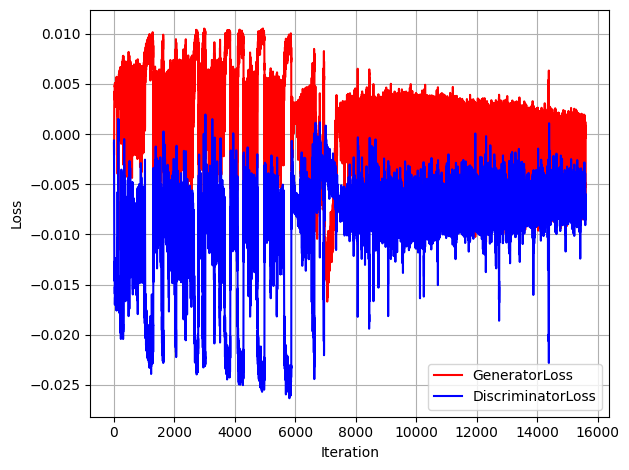

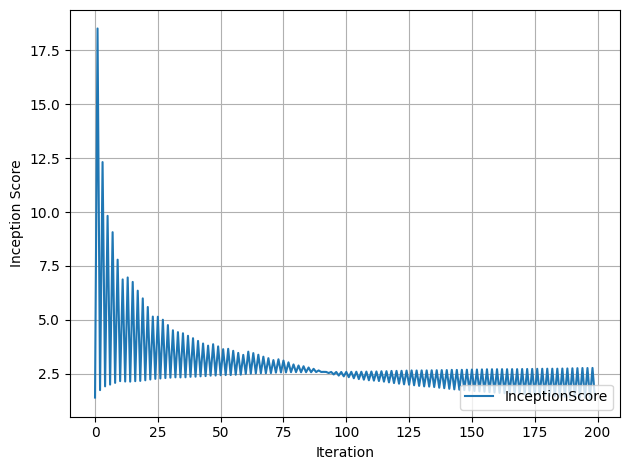

In [7]:
wgan.train()

Start training!


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 1/100
Average Discriminator loss: -1.2645993408603737
Average Generator loss: 2.7014681404599776

inception_score: tensor(1.6492)
fid: tensor(5.6431) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 2/100
Average Discriminator loss: -1.4519891433286456
Average Generator loss: 4.032031191369662

inception_score: tensor(1.9697)
fid: tensor(5.0604) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 3/100
Average Discriminator loss: -1.5379039596837873
Average Generator loss: 5.293515751950252

inception_score: tensor(2.0888)
fid: tensor(4.1012) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 4/100
Average Discriminator loss: -1.6434364448785066
Average Generator loss: 6.447783377260352

inception_score: tensor(2.0996)
fid: tensor(3.6553) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 5/100
Average Discriminator loss: -1.7700686482306665
Average Generator loss: 7.549602029529901

inception_score: tensor(2.1750)
fid: tensor(3.2133) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 6/100
Average Discriminator loss: -1.8891183982312711
Average Generator loss: 8.42690890795018

inception_score: tensor(2.2530)
fid: tensor(3.0122) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 7/100
Average Discriminator loss: -1.9736387558817017
Average Generator loss: 9.06317282528122

inception_score: tensor(2.3246)
fid: tensor(2.9305) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 8/100
Average Discriminator loss: -2.063741983656282
Average Generator loss: 9.57106890832671

inception_score: tensor(2.3362)
fid: tensor(2.8011) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 9/100
Average Discriminator loss: -2.1021511921953633
Average Generator loss: 9.856389792365396

inception_score: tensor(2.3562)
fid: tensor(2.8178) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 10/100
Average Discriminator loss: -2.1563697724782216
Average Generator loss: 10.118897156360058

inception_score: tensor(2.3751)
fid: tensor(2.6782) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 11/100
Average Discriminator loss: -2.2366334029716506
Average Generator loss: 10.42785934813859

inception_score: tensor(2.4041)
fid: tensor(2.5069) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 12/100
Average Discriminator loss: -2.3035027825593963
Average Generator loss: 10.688642456092769

inception_score: tensor(2.4620)
fid: tensor(2.4177) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 13/100
Average Discriminator loss: -2.3746872091384814
Average Generator loss: 10.953095958650817

inception_score: tensor(2.5010)
fid: tensor(2.3453) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 14/100
Average Discriminator loss: -2.4274213122205652
Average Generator loss: 11.197738617426637

inception_score: tensor(2.5268)
fid: tensor(2.2359) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 15/100
Average Discriminator loss: -2.467581081824202
Average Generator loss: 11.442858486183178

inception_score: tensor(2.5715)
fid: tensor(2.1448) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 16/100
Average Discriminator loss: -2.5391930558320244
Average Generator loss: 11.70713691268928

inception_score: tensor(2.5944)
fid: tensor(2.0524) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 17/100
Average Discriminator loss: -2.6072180673689336
Average Generator loss: 11.98461149980175

inception_score: tensor(2.6101)
fid: tensor(2.0148) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 18/100
Average Discriminator loss: -2.6641446949968492
Average Generator loss: 12.240827728275136

inception_score: tensor(2.6198)
fid: tensor(1.9330) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 19/100
Average Discriminator loss: -2.7230951485611175
Average Generator loss: 12.52963453948538

inception_score: tensor(2.6369)
fid: tensor(1.8634) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 20/100
Average Discriminator loss: -2.7808138588688167
Average Generator loss: 12.816048087284733

inception_score: tensor(2.6528)
fid: tensor(1.8289) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 21/100
Average Discriminator loss: -2.8208154223601176
Average Generator loss: 13.06617664627649

inception_score: tensor(2.6536)
fid: tensor(1.7930) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 22/100
Average Discriminator loss: -2.766433138730838
Average Generator loss: 13.155335901839125

inception_score: tensor(2.6666)
fid: tensor(1.7534) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 23/100
Average Discriminator loss: -2.79991332222339
Average Generator loss: 13.271619351603581

inception_score: tensor(2.6819)
fid: tensor(1.7139) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 24/100
Average Discriminator loss: -2.8309271231171294
Average Generator loss: 13.39457891925246

inception_score: tensor(2.7194)
fid: tensor(1.6404) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 25/100
Average Discriminator loss: -2.8311571905021675
Average Generator loss: 13.459630749095709

inception_score: tensor(2.7392)
fid: tensor(1.6061) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 26/100
Average Discriminator loss: -2.7404926627276454
Average Generator loss: 13.355750090323198

inception_score: tensor(2.7515)
fid: tensor(1.6278) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 27/100
Average Discriminator loss: -2.7073528287124775
Average Generator loss: 13.301228549794876

inception_score: tensor(2.7665)
fid: tensor(1.6051) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 28/100
Average Discriminator loss: -2.6940658738970544
Average Generator loss: 13.296913995240361

inception_score: tensor(2.7757)
fid: tensor(1.6265) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 29/100
Average Discriminator loss: -2.668494547710274
Average Generator loss: 13.314808349124263

inception_score: tensor(2.7908)
fid: tensor(1.6086) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 30/100
Average Discriminator loss: -2.679662064405986
Average Generator loss: 13.394847031173288

inception_score: tensor(2.7926)
fid: tensor(1.5899) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 31/100
Average Discriminator loss: -2.6949512778089604
Average Generator loss: 13.481129130658234

inception_score: tensor(2.8118)
fid: tensor(1.5430) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 32/100
Average Discriminator loss: -2.7180388521239647
Average Generator loss: 13.588193577493374

inception_score: tensor(2.8178)
fid: tensor(1.5124) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 33/100
Average Discriminator loss: -2.748975361838847
Average Generator loss: 13.718543845404694

inception_score: tensor(2.8448)
fid: tensor(1.4651) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 34/100
Average Discriminator loss: -2.707487998381721
Average Generator loss: 13.75947223353687

inception_score: tensor(2.8535)
fid: tensor(1.4446) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 35/100
Average Discriminator loss: -2.6912948656980724
Average Generator loss: 13.73851252269723

inception_score: tensor(2.8635)
fid: tensor(1.4232) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 36/100
Average Discriminator loss: -2.698254504933903
Average Generator loss: 13.776465790261359

inception_score: tensor(2.8659)
fid: tensor(1.4220) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 37/100
Average Discriminator loss: -2.7135953548795473
Average Generator loss: 13.85068484770595

inception_score: tensor(2.8649)
fid: tensor(1.3940) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 38/100
Average Discriminator loss: -2.7205222608894237
Average Generator loss: 13.905719995855602

inception_score: tensor(2.8689)
fid: tensor(1.3862) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 39/100
Average Discriminator loss: -2.704504477383384
Average Generator loss: 13.964798955870137

inception_score: tensor(2.8808)
fid: tensor(1.3769) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 40/100
Average Discriminator loss: -2.7209442228129586
Average Generator loss: 14.050214945080763

inception_score: tensor(2.8928)
fid: tensor(1.3478) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 41/100
Average Discriminator loss: -2.71982073142287
Average Generator loss: 14.125123470439211

inception_score: tensor(2.8860)
fid: tensor(1.3339) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 42/100
Average Discriminator loss: -2.7186872314696426
Average Generator loss: 14.190453385872829

inception_score: tensor(2.8894)
fid: tensor(1.3215) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 43/100
Average Discriminator loss: -2.74425608040565
Average Generator loss: 14.248465120219267

inception_score: tensor(2.8843)
fid: tensor(1.2972) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 44/100
Average Discriminator loss: -2.7366980657392315
Average Generator loss: 14.289212495466316

inception_score: tensor(2.8900)
fid: tensor(1.2843) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 45/100
Average Discriminator loss: -2.7378652172638076
Average Generator loss: 14.308491419960461

inception_score: tensor(2.8940)
fid: tensor(1.2593) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 46/100
Average Discriminator loss: -2.749607690094234
Average Generator loss: 14.35830600168909

inception_score: tensor(2.9022)
fid: tensor(1.2446) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 47/100
Average Discriminator loss: -2.7305871796940564
Average Generator loss: 14.358133832577044

inception_score: tensor(2.9058)
fid: tensor(1.2215) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 48/100
Average Discriminator loss: -2.7075314347348156
Average Generator loss: 14.329659487602388

inception_score: tensor(2.9041)
fid: tensor(1.2184) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 49/100
Average Discriminator loss: -2.7106758566514295
Average Generator loss: 14.33828745160519

inception_score: tensor(2.9117)
fid: tensor(1.2205) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 50/100
Average Discriminator loss: -2.7042230173986024
Average Generator loss: 14.367490969342299

inception_score: tensor(2.9177)
fid: tensor(1.2063) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 51/100
Average Discriminator loss: -2.707515735604579
Average Generator loss: 14.411670545793138

inception_score: tensor(2.9260)
fid: tensor(1.1756) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 52/100
Average Discriminator loss: -2.708897293328778
Average Generator loss: 14.445401669985062

inception_score: tensor(2.9265)
fid: tensor(1.1567) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 53/100
Average Discriminator loss: -2.72285491754569
Average Generator loss: 14.498380426077752

inception_score: tensor(2.9374)
fid: tensor(1.1392) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 54/100
Average Discriminator loss: -2.739129503226838
Average Generator loss: 14.540473532610894

inception_score: tensor(2.9341)
fid: tensor(1.1327) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 55/100
Average Discriminator loss: -2.7504524806355906
Average Generator loss: 14.586101808216606

inception_score: tensor(2.9414)
fid: tensor(1.1192) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 56/100
Average Discriminator loss: -2.771423816392855
Average Generator loss: 14.617645670666663

inception_score: tensor(2.9448)
fid: tensor(1.0976) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 57/100
Average Discriminator loss: -2.7931427639826136
Average Generator loss: 14.645448754804256

inception_score: tensor(2.9505)
fid: tensor(1.1026) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 58/100
Average Discriminator loss: -2.7466989236381103
Average Generator loss: 14.596895122266549

inception_score: tensor(2.9505)
fid: tensor(1.0968) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 59/100
Average Discriminator loss: -2.706795801620474
Average Generator loss: 14.596845120745268

inception_score: tensor(2.9606)
fid: tensor(1.0756) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 60/100
Average Discriminator loss: -2.6771416197684155
Average Generator loss: 14.574850210238598

inception_score: tensor(2.9604)
fid: tensor(1.0647) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 61/100
Average Discriminator loss: -2.658412845184601
Average Generator loss: 14.535963469036565

inception_score: tensor(2.9669)
fid: tensor(1.0572) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 62/100
Average Discriminator loss: -2.6491519946643867
Average Generator loss: 14.478389247644898

inception_score: tensor(2.9715)
fid: tensor(1.0415) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 63/100
Average Discriminator loss: -2.644556674033011
Average Generator loss: 14.419333467817205

inception_score: tensor(2.9788)
fid: tensor(1.0299) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 64/100
Average Discriminator loss: -2.647361792351055
Average Generator loss: 14.405606513481754

inception_score: tensor(2.9826)
fid: tensor(1.0143) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 65/100
Average Discriminator loss: -2.657341428628812
Average Generator loss: 14.411513461325413

inception_score: tensor(2.9864)
fid: tensor(1.0196) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 66/100
Average Discriminator loss: -2.6553715108313094
Average Generator loss: 14.415779592896282

inception_score: tensor(2.9906)
fid: tensor(1.0123) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 67/100
Average Discriminator loss: -2.661815473437202
Average Generator loss: 14.42360072593225

inception_score: tensor(2.9925)
fid: tensor(0.9991) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 68/100
Average Discriminator loss: -2.6673357489465794
Average Generator loss: 14.434167872072052

inception_score: tensor(2.9927)
fid: tensor(0.9991) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 69/100
Average Discriminator loss: -2.664492836196615
Average Generator loss: 14.410462273023843

inception_score: tensor(2.9936)
fid: tensor(0.9953) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 70/100
Average Discriminator loss: -2.6706600575958594
Average Generator loss: 14.364120912920315

inception_score: tensor(3.0004)
fid: tensor(0.9812) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 71/100
Average Discriminator loss: -2.6879563519820966
Average Generator loss: 14.326829451197169

inception_score: tensor(2.9986)
fid: tensor(0.9782) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 72/100
Average Discriminator loss: -2.669288389172645
Average Generator loss: 14.272839393559577

inception_score: tensor(3.0016)
fid: tensor(0.9684) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 73/100
Average Discriminator loss: -2.6734995620165245
Average Generator loss: 14.207366291850983

inception_score: tensor(2.9998)
fid: tensor(0.9593) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 74/100
Average Discriminator loss: -2.68643702633504
Average Generator loss: 14.107437860587263

inception_score: tensor(3.0047)
fid: tensor(0.9542) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 75/100
Average Discriminator loss: -2.69899923912751
Average Generator loss: 14.010906754912984

inception_score: tensor(3.0108)
fid: tensor(0.9526) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 76/100
Average Discriminator loss: -2.702434460432822
Average Generator loss: 13.90714910731735

inception_score: tensor(3.0122)
fid: tensor(0.9484) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 77/100
Average Discriminator loss: -2.6951734612744254
Average Generator loss: 13.758533048291842

inception_score: tensor(3.0143)
fid: tensor(0.9335) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 78/100
Average Discriminator loss: -2.6710266413010673
Average Generator loss: 13.658185477858993

inception_score: tensor(3.0188)
fid: tensor(0.9248) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 79/100
Average Discriminator loss: -2.6616262634301724
Average Generator loss: 13.569636079278697

inception_score: tensor(3.0223)
fid: tensor(0.9205) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 80/100
Average Discriminator loss: -2.6579732464030923
Average Generator loss: 13.492550534189034

inception_score: tensor(3.0206)
fid: tensor(0.9107) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 81/100
Average Discriminator loss: -2.653395104131049
Average Generator loss: 13.419631248155456

inception_score: tensor(3.0323)
fid: tensor(0.9070) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 82/100
Average Discriminator loss: -2.6523259089675193
Average Generator loss: 13.34184721860338

inception_score: tensor(3.0350)
fid: tensor(0.9022) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 83/100
Average Discriminator loss: -2.658030946865467
Average Generator loss: 13.250753338711384

inception_score: tensor(3.0380)
fid: tensor(0.8957) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 84/100
Average Discriminator loss: -2.657223830261252
Average Generator loss: 13.13853290632267

inception_score: tensor(3.0423)
fid: tensor(0.8882) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 85/100
Average Discriminator loss: -2.627461331759244
Average Generator loss: 13.047224726947094

inception_score: tensor(3.0464)
fid: tensor(0.8808) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 86/100
Average Discriminator loss: -2.608208260837288
Average Generator loss: 12.988390516769641

inception_score: tensor(3.0548)
fid: tensor(0.8659) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 87/100
Average Discriminator loss: -2.596535163151329
Average Generator loss: 12.94582306106613

inception_score: tensor(3.0652)
fid: tensor(0.8606) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 88/100
Average Discriminator loss: -2.594749840252272
Average Generator loss: 12.91400466829165

inception_score: tensor(3.0677)
fid: tensor(0.8560) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 89/100
Average Discriminator loss: -2.595942226241098
Average Generator loss: 12.881928968770003

inception_score: tensor(3.0704)
fid: tensor(0.8467) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 90/100
Average Discriminator loss: -2.5958446401530915
Average Generator loss: 12.848284843345398

inception_score: tensor(3.0726)
fid: tensor(0.8467) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 91/100
Average Discriminator loss: -2.597692522786481
Average Generator loss: 12.816565029428068

inception_score: tensor(3.0786)
fid: tensor(0.8424) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 92/100
Average Discriminator loss: -2.6070184937182246
Average Generator loss: 12.786848378630403

inception_score: tensor(3.0828)
fid: tensor(0.8380) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 93/100
Average Discriminator loss: -2.6241909963043364
Average Generator loss: 12.76118916502571

inception_score: tensor(3.0920)
fid: tensor(0.8473) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 94/100
Average Discriminator loss: -2.629779992453511
Average Generator loss: 12.721567948766975

inception_score: tensor(3.0957)
fid: tensor(0.8499) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 95/100
Average Discriminator loss: -2.630582694649098
Average Generator loss: 12.673732892296172

inception_score: tensor(3.1030)
fid: tensor(0.8390) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 96/100
Average Discriminator loss: -2.627831422066257
Average Generator loss: 12.646892784412106

inception_score: tensor(3.1064)
fid: tensor(0.8317) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 97/100
Average Discriminator loss: -2.627958029281238
Average Generator loss: 12.636541771514135

inception_score: tensor(3.1078)
fid: tensor(0.8264) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 98/100
Average Discriminator loss: -2.624173063359017
Average Generator loss: 12.632420175001688

inception_score: tensor(3.1139)
fid: tensor(0.8226) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 99/100
Average Discriminator loss: -2.626240431640212
Average Generator loss: 12.630402810531974

inception_score: tensor(3.1174)
fid: tensor(0.8145) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 100/100
Average Discriminator loss: -2.6158335849252317
Average Generator loss: 12.620565432350222

inception_score: tensor(3.1200)
fid: tensor(0.8065) 

Training finished!


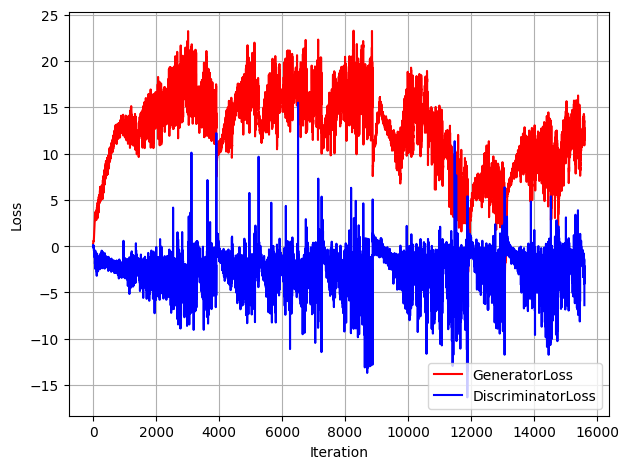

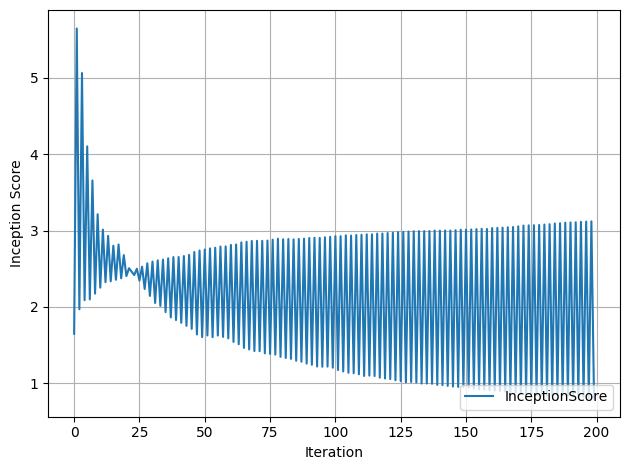

In [8]:
wgan_gp.train()